In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import time
import concurrent.futures

In [2]:
isocronas = pd.read_csv('../../../Isocronas/Regression_Iso.txt', header = 0)

In [3]:
from scipy.interpolate import interp1d

In [4]:
f1 = interp1d(isocronas['(B-V)TurnOff'],  isocronas['Age'],kind= 'linear')

## M45, E(B-V)=0.03 (Dias et. al.)

In [5]:
m45 = pd.read_csv('RegressaoM45.txt', header = 0)
E=0.03
m45.head()

,Slope,Intercept,Slope_Error,Intercept_Error,TurnOffColor
0,5.950881,6.420497,0.030356,0.023126,-0.11


In [6]:
idade1 = f1(m45['TurnOffColor ']-E)
idade1 = np.around(idade1,1)[0]
idade1

8.0

In [7]:
#idade1 = 8.1

In [8]:
isocro1 = isocronas[isocronas['Age'] == idade1]
isocro1

,Age,Slope,Intercept,Slope_Error,Intercept_Error,R_Value,(B-V)TurnOff,MvTurnOff,Ajustadas/Total
35,8.0,5.6861,1.107006,0.026318,0.01303,0.99985,-0.14,-0.78,0.38095238095238093= 16/42


In [9]:
## Método do Slope do Aglomerado
def distancia(a,b,b0,E):
    return 10**((a*E + (b-b0) - E*3.1 + 5 )/5)
d1 = distancia(m45['Slope'].item(), m45[' Intercept'].item(), isocro1['Intercept'].item(),E)
d1

120.17205762009026

In [10]:
i1 = pd.read_csv('m45.txt',comment = '#', skiprows = 51, header = None, usecols = [1,2], names = ['V','B-V'], delim_whitespace = True)
i1.head()

,V,B-V
0,9.47,0.48
1,11.99,0.93
2,12.62,1.08
3,10.51,0.71
4,10.79,0.70


In [64]:
len(i1)

270

In [11]:
iso = pd.read_csv('../../../Isocronas/isocro.csv', header = 0)

idades = iso['log(Age)']
age = np.array([])
for element in idades:
    if element in age:
        continue
    elif element not in age:
        age = np.append(age,element)

iso1 = iso[iso['log(Age)']==idade1]

In [12]:
#np.unique(iso['log(Age)'])

Text(0, 0.5, '$V$')

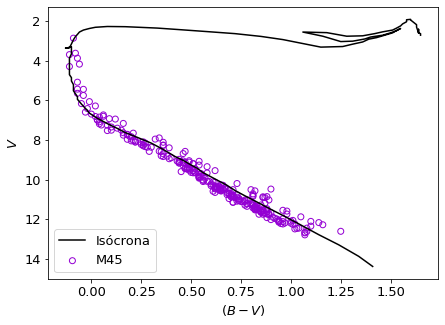

In [13]:
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 


font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

fig,ax = plt.subplots(figsize=(7,5)) #(figsize=(10,8))
plt.gca().invert_yaxis()
plt.plot(iso1['(B-V)o'] + E,iso1['Mv'] +5*np.log10(d1/10)+3.1*E , label = 'Isócrona', color = 'black', zorder = 10)
plt.scatter(i1['B-V'] ,i1['V'], label = 'M45', color = 'none', edgecolor = 'darkviolet')
plt.legend(frameon=True)
plt.xlabel(r"$(B-V)$")
plt.ylabel(r"$V$")

In [14]:
def jpt(X,Y):
    array = (X - Y)  
    array = np.sum(array**2, axis = 1)
    A, B = np.argpartition(array, 1)[0:2]
    return A,B


def frayn(X1,X2,X3):
  h = 2*((X3[0]-X1[0])*(X2[1]-X1[1]) - (X3[1]-X1[1])*(X2[0]-X1[0]))/np.sqrt(dist(X1,X2))
  return h**2

def dist(X,Y):
  distancia = 0
  for j in range(len(X)):
    distancia+= (X[j] - Y[j])**2
  return distancia


In [15]:
modulodist_inicial = 5*np.log10(d1/10) + E*3.1

arrays_de_incremento = np.arange(0,3.05,0.05)

subtracao_distancias = np.concatenate((-1*np.flip(arrays_de_incremento[1:]),arrays_de_incremento))
modulo_distancia = subtracao_distancias + modulodist_inicial

Yiso = np.zeros((len(modulo_distancia), len(iso1)))

for i in range(len(modulo_distancia)):
  Yiso[i] = iso1['Mv'] + modulo_distancia[i]

Xiso = np.zeros_like(Yiso)
Xiso[:] = iso1['(B-V)o'] + E

ISO = np.dstack((Xiso,Yiso))
ISO = np.unique(ISO,axis=1)

Xaglo = i1['B-V'] 
Yaglo = i1['V']
AGLO = np.vstack((Xaglo,Yaglo)).T

chisquared = np.zeros_like(modulo_distancia)
Beauchamp = np.zeros_like(modulo_distancia)

start = time.time()
for i in range(len(ISO)):
  for j in range(len(AGLO)):
    C,D = jpt(AGLO[j],ISO[i])
    final = frayn(ISO[i][C], ISO[i][D],AGLO[j])
    chisquared[i] += final
    Beauchamp[i] += final*10**(-0.4*AGLO[j][1])
end = time.time()
print('Tempo decorrido: ', end-start)

Tempo decorrido:  1.4585683345794678


Text(0.5, 0.98, 'M45')

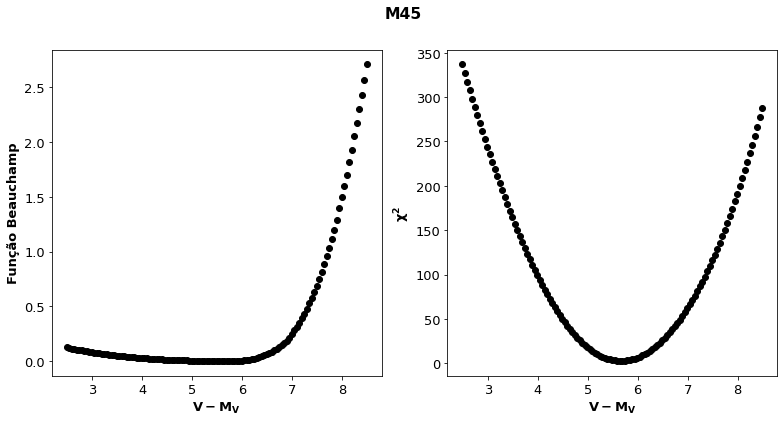

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (13,6))
ax1.scatter(modulo_distancia, Beauchamp, color = 'k')
ax2.scatter(modulo_distancia, chisquared, color = 'k')
ax1.set_xlabel(r'$ \mathbf{V - M_V}$')
ax2.set_xlabel(r'$ \mathbf{V - M_V}$')
ax1.set_ylabel('Função Beauchamp', fontweight = 'bold')
ax2.set_ylabel(r'$ \mathbf{\chi^2}$')

fig.suptitle('M45', fontweight = 'bold')



In [17]:
beau = np.where(Beauchamp==min(Beauchamp))[0]
noweight = np.where(chisquared==min(chisquared))[0] ## Definindo os valores onde a funcao definida é mínima

In [18]:
5*np.log10(136) - 5

5.667694541851088

In [20]:
observado = 5*np.log10(136) - 5  #V-Mv

minimo_beau = modulo_distancia[beau]
minimo_chi = modulo_distancia[noweight]
minimo_chi

array([5.64201749])

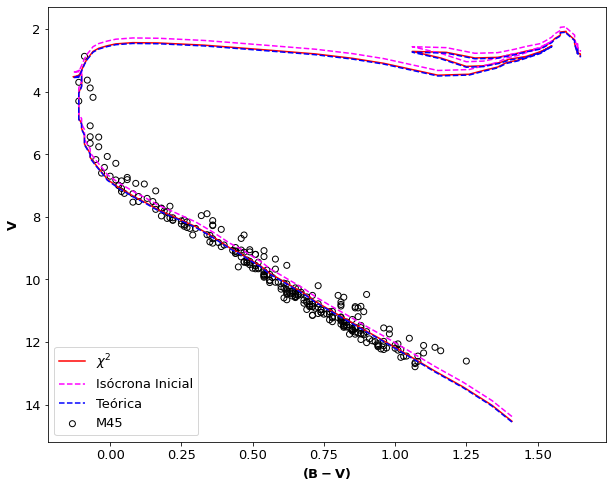

In [20]:
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 


font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

fig,ax = plt.subplots(figsize=(10,8)) #(figsize=(10,8))
plt.gca().invert_yaxis()
#plt.plot(iso1['(B-V)o'] + E, iso1['Mv'] + minimo_beau , label = 'Beauchamp', color = 'green', zorder = 10)
plt.plot(iso1['(B-V)o'] + E, iso1['Mv'] + minimo_chi , label = r'$ \chi^2 $', color = 'red', zorder = 10)  
plt.plot(iso1['(B-V)o'] + E,iso1['Mv'] + modulodist_inicial , '--', label = 'Isócrona Inicial', color = 'magenta', zorder = 10)
plt.plot(iso1['(B-V)o'] + E,iso1['Mv'] + observado , '--', label = 'Teórica', color = 'blue', zorder = 10)
plt.scatter(i1['B-V'] ,i1['V'], label = 'M45', color = 'none', edgecolor = 'black')
plt.legend(frameon=True)
plt.xlabel(r"$ \mathbf{(B-V)}$")
plt.ylabel(r"$ \mathbf{V}$");


In [72]:
BeauchampAGES = np.zeros_like(age)
chisquaredAGES = np.zeros_like(age)

start = time.time()
for j in range(len(age)):
  data = iso[iso['log(Age)'] == age[j]]
  Xiso = np.array(data['(B-V)o'] + E)
  Yiso = np.array(data['Mv'] + minimo_chi)
  ISO = (np.vstack((Xiso,Yiso)).T)
  ISO = np.unique(ISO, axis=0)
  for i in range(len(AGLO)):
    C,D = jpt(AGLO[i],ISO)
    final = frayn(ISO[C], ISO[D],AGLO[i])
    chisquaredAGES[j] += final
    BeauchampAGES[j] += final*10**(-0.4*AGLO[i][1])
end = time.time()
print('Tempo decorrido: ', end-start)

Tempo decorrido:  0.34896159172058105


Text(0.5, 0.98, 'M45')

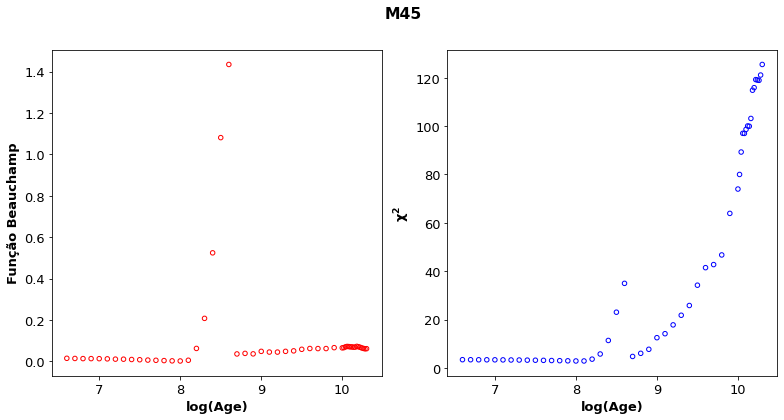

In [92]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (13,6))
ax1.scatter(age, BeauchampAGES, color = 'none', edgecolor = 'red', s = 20)
ax2.scatter(age, chisquaredAGES, color = 'none', edgecolor = 'blue', s = 20)
ax1.set_xlabel('log(Age)',  fontweight = 'bold')
ax2.set_xlabel('log(Age)',  fontweight = 'bold')
ax1.set_ylabel('Função Beauchamp',  fontweight = 'bold')
ax2.set_ylabel(r'$ \mathbf{\chi^2}$')
fig.suptitle('M45', fontweight = 'bold')

#from google.colab import files
#plt.savefig('aglomerado1chiAGES.png', format = 'png')
#files.download('aglomerado1chiAGES.png') 

In [91]:
BeauchampAGES = np.zeros_like(age)
chisquaredAGES = np.zeros_like(age)

for j in range(len(age)):
    data = iso[iso['log(Age)'] == age[j]]
    Xiso = np.array(data['(B-V)o'] + E)
    Yiso = np.array(data['Mv'] + minimo_chi)
    ISO = np.dstack((Xiso,Yiso))
    ISO = np.unique(ISO,axis=1)
    for i in range(len(AGLO)):
        C,D = jpt(AGLO[i],ISO[0])
        final = frayn(ISO[0][C], ISO[0][D],AGLO[i])
        chisquaredAGES[j] += final
        BeauchampAGES[j] += final*10**(-0.4*AGLO[i][1])

In [116]:
a = np.zeros(5)
b = np.zeros(5)

oi = [8.3,8.4,8.5,8.6,8.7]
for j in range(len(oi)):
    data = iso[iso['log(Age)'] == oi[j]]
    Xiso = np.array(data['(B-V)o'] + E)
    Yiso = np.array(data['Mv'] + minimo_chi)
    ISO = np.dstack((Xiso,Yiso))
    ISO = np.unique(ISO,axis=1)
    for i in range(len(AGLO)):
        C,D = jpt(AGLO[i],ISO[0])
        final = frayn(ISO[0][C], ISO[0][D],AGLO[i])
        a[j] += final
        b[j] += final*10**(-0.4*AGLO[i][1])
a

array([ 5.74333992, 11.34627604, 23.03319218, 34.96274885,  4.72655161])

In [123]:
len(i1)

270

5.103399722672663


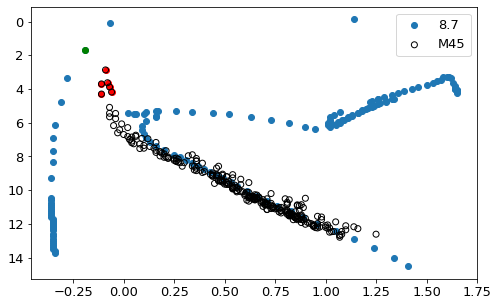

In [172]:
plt.figure(figsize=(8,5))
oi = [8.3,8.4,8.5,8.6,8.7]
oi = [8.7]
for element in oi:#age[25:40]:
  data = iso[iso['log(Age)'] == element]
  Xiso = np.array(data['(B-V)o'] + E)
  Yiso = np.array(data['Mv'] + minimo_chi)
  plt.scatter(Xiso,Yiso,label = str(element))
  local = np.where(Xiso == min(Xiso))[0][0]
  plt.scatter(Xiso[local-7],Yiso[local-7], color = 'green')
  a = [Xiso[local-7],Yiso[local-7]]
  b = [i1['B-V'][indices[0:2]],i1['V'][indices[0:2]]]
  print(np.sum(dist(a,b)))

for element in indices:
    plt.scatter(i1['B-V'][element] ,i1['V'][element], color = 'red')
plt.scatter(i1['B-V'] ,i1['V'], color = 'none', edgecolor = 'black', label = 'M45')
plt.legend()
plt.gca().invert_yaxis()

2.717785082193406
3.9994832684105344
5.618262154097556
7.532641039784572


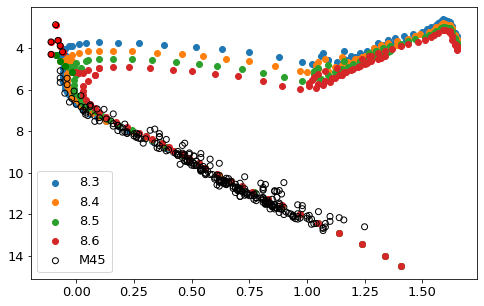

In [171]:
plt.figure(figsize=(8,5))
oi = [8.3,8.4,8.5,8.6]
for element in oi:#age[25:40]:
  data = iso[iso['log(Age)'] == element]
  Xiso = np.array(data['(B-V)o'] + E)
  Yiso = np.array(data['Mv'] + minimo_chi)
  plt.scatter(Xiso,Yiso,label = str(element))
  local = np.where(Xiso == min(Xiso))[0][0]
  plt.scatter(Xiso[local],Yiso[local], color = 'green')
  a = [Xiso[local],Yiso[local]]
  b = [i1['B-V'][indices[0:2]],i1['V'][indices[0:2]]]
  print(np.sum(dist(a,b)))
    
for element in indices:
    plt.scatter(i1['B-V'][element] ,i1['V'][element], color = 'red')
plt.scatter(i1['B-V'] ,i1['V'], color = 'none', edgecolor = 'black', label = 'M45')
plt.legend()
plt.gca().invert_yaxis()

In [137]:
opa = sorted(i1['V'])[0:6]
indices = []
for element in opa:
    indices.append(np.where(i1['V'] == element)[0][0])
indices

[105, 126, 33, 57, 69, 42]

In [151]:
i1['V'][indices]

105    2.87
126    3.63
33     3.70
57     3.88
69     4.18
42     4.30
Name: V, dtype: float64

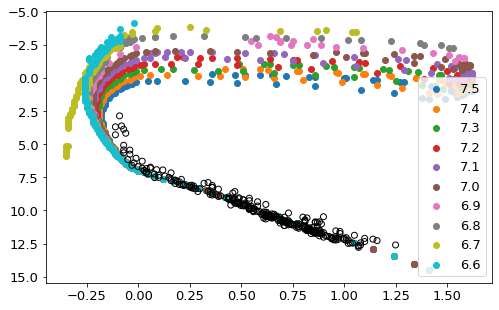

In [179]:
plt.figure(figsize=(8,5))
oi = age[40:]
for element in oi:#age[25:40]:
  data = iso[iso['log(Age)'] == element]
  Xiso = np.array(data['(B-V)o'] + E)
  Yiso = np.array(data['Mv'] + minimo_chi)
  plt.scatter(Xiso,Yiso,label = str(element))
plt.scatter(i1['B-V'] ,i1['V'], color = 'none', edgecolor = 'black')
plt.legend()
plt.gca().invert_yaxis()

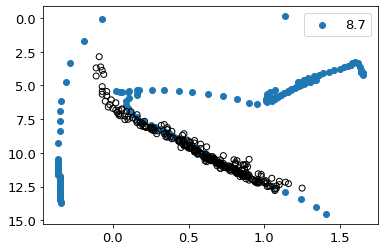

In [115]:
 data = iso[iso['log(Age)'] == 8.7]
Xiso = np.array(data['(B-V)o'] + E)
Yiso = np.array(data['Mv'] + minimo_chi)
plt.scatter(Xiso,Yiso,label = str(element))
#plt.scatter(Xiso[-1],Yiso[-1], color = 'red')
plt.scatter(i1['B-V'] ,i1['V'], color = 'none', edgecolor = 'black')
plt.legend()
plt.gca().invert_yaxis()

In [23]:
newage = age[25:45]
newage

array([9. , 8.9, 8.8, 8.7, 8.6, 8.5, 8.4, 8.3, 8.2, 8.1, 8. , 7.9, 7.8,
       7.7, 7.6, 7.5, 7.4, 7.3, 7.2, 7.1])

In [24]:
Xaglo = i1['B-V'] 
Yaglo = i1['V']
AGLO = np.vstack((Xaglo,Yaglo)).T

Beauchamp_n_ages = np.zeros((len(newage),len(modulo_distancia)))
chisquared_n_ages = np.zeros((len(newage),len(modulo_distancia)))

start = time.time()
for w in range(len(newage)):
  data = iso[iso['log(Age)'] == newage[w]]
  Yiso = np.zeros((len(modulo_distancia), len(data)))
  for k in range(len(modulo_distancia)):
    Yiso[k] = data['Mv'] + modulo_distancia[k]
  Xiso = np.zeros_like(Yiso)
  Xiso[:] = data['(B-V)o'] + E
  ISO = np.dstack((Xiso,Yiso))
  ISO = np.unique(ISO,axis=1)
  chisquared = np.zeros_like(modulo_distancia)
  Beauchamp = np.zeros_like(modulo_distancia)
  for i in range(len(ISO)):
    for j in range(len(AGLO)):
      C,D = jpt(AGLO[j],ISO[i])
      if C==D:
          print(j,i)
          final = frayn(ISO[i][C], ISO[i][C+1],AGLO[j])
      else:
          final = frayn(ISO[i][C], ISO[i][D],AGLO[j])    
      chisquared_n_ages[w][i] += final
      Beauchamp_n_ages[w][i] += final*10**(-0.4*AGLO[j][1])
end = time.time()
print('Tempo decorrido: ', end-start)

Tempo decorrido:  16.938668966293335


In [31]:
def chi_to_age(IDADE):
  data = iso[iso['log(Age)'] == IDADE]
  Yiso = np.zeros((len(modulo_distancia), len(data)))
  for k in range(len(modulo_distancia)):
    Yiso[k] = data['Mv'] + modulo_distancia[k]
  Xiso = np.zeros_like(Yiso)
  Xiso[:] = data['(B-V)o'] + E
  ISO = np.dstack((Xiso,Yiso))
  ISO = np.unique(ISO,axis=1)
  A = np.zeros(len(ISO))
  B = np.zeros(len(ISO))
  for i in range(len(ISO)):
    for j in range(len(AGLO)):
      C,D = jpt(AGLO[j],ISO[i])
      final = frayn(ISO[i][C], ISO[i][D],AGLO[j])
      A[i] += final
      B[i] += final*10**(-0.4*AGLO[j][1])
  return A,B

In [32]:
newage = age#[25:45]

start = time.time()
with concurrent.futures.ProcessPoolExecutor() as executor:
  results = executor.map(chi_to_age,newage)
end = time.time()

chi = []
beau = []
for i in results:
    chi.append(i[0])
    beau.append(i[1])
    
resultado = np.array(resultado)
print(end-start)



9.911689758300781


Text(0.5, 1.0, 'M45')

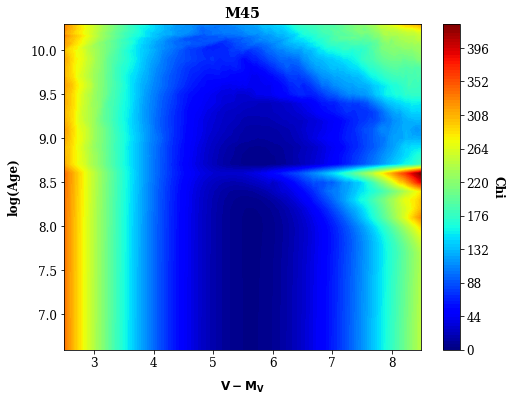

In [34]:
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 


font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)


import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import ImageGrid
z = chi
x = modulo_distancia
y = newage

# Set colomap
cmap = cm.get_cmap('jet')
cmap = cm.jet

fig,ax = plt.subplots(figsize=(8,6)) #(figsize=(10,8))
levels = len(modulo_distancia)
im  = ax.contourf(x, y, z, levels= levels, antialiased=False, cmap=cmap)


cbar = fig.colorbar(im)
cbar.set_label('Chi', fontweight = 'bold', rotation=270, labelpad=15)

ax.set_xlabel(r'$ \mathbf{V - M_V}$', fontweight = 'bold', labelpad=10)
ax.set_ylabel('log(Age)', fontweight = 'bold', labelpad=10)
ax.set_title('M45', fontweight = 'bold')
#plt.savefig('ag1_colourfill_teste_beau.png', format = 'png')

In [35]:
beau = np.array(beau)
chi = np.array(chi)

In [41]:
chi

array([[323.76321025, 318.90505481, 311.16046677, ..., 303.92119898,
        306.40763927, 312.30297694],
       [331.93462072, 320.86415892, 312.74674376, ..., 297.9730068 ,
        299.42986302, 309.61367184],
       [327.8396262 , 318.40808626, 311.80213108, ..., 285.01146633,
        288.32777444, 293.51839484],
       ...,
       [336.84988918, 326.86811677, 317.00218741, ..., 230.36120854,
        237.8038974 , 245.53957937],
       [336.84944691, 326.86794938, 317.00181314, ..., 230.480202  ,
        238.07853717, 245.86382761],
       [336.84944691, 326.86794938, 317.00186783, ..., 230.87887085,
        238.49252245, 246.31309751]])

In [51]:
a=np.where(chi==np.min(chi))
a

(array([34]), array([63]))

In [54]:
b = a[0][0]

In [55]:
newage[b], modulo_distancia[63]

(8.1, 5.64201748674724)